In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the Repeat-Vector model

In [3]:
# decoder input: original time series value at last time step

class RepeatVector(object):

    def __init__(self, hidden_num, inputs, optimizer=None, reverse=True,):
        # inputs is a list with length step_num.
        # each element in inputs has size (batch_num,elem_num)
        
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
 

        self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)
        self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)

        
        
        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)
            
        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            #Repeat vector
            dec_inputs = [self.z_codes[-1] for _ in range(len(self.z_codes))]

            (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)
 
            if reverse:
                dec_outputs = dec_outputs[::-1]

            dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
            dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
            self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
       

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))
   
        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load KDD99 Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
#squeeze: remove [1]dim
#split: split p_input into step_num tensors along dim 1.
# so for t in tf.split(p_input, step_num, 1), t has size (batch_num,1,elem_num)
# and each element in p_inputs has shape(batch_num,elem_num), totally step_num elements


In [8]:
ae = RepeatVector(hidden_num, p_inputs)

# Training

iter 1: 0.567012
iter 2: 0.271653
iter 3: 0.143744
iter 4: 0.108559
iter 5: 0.103399
iter 6: 0.1003
iter 7: 0.0767459
iter 8: 0.0587953
iter 9: 0.0566566
iter 10: 0.0484292
iter 11: 0.0410509
iter 12: 0.0371616
iter 13: 0.0330496
iter 14: 0.0297997
iter 15: 0.0304749
iter 16: 0.0319256
iter 17: 0.025337
iter 18: 0.025473
iter 19: 0.0215826
iter 20: 0.0278274
iter 21: 0.0200991
iter 22: 0.0196095
iter 23: 0.0192225
iter 24: 0.0175234
iter 25: 0.019391
iter 26: 0.0150966
iter 27: 0.0142395
iter 28: 0.0181379
iter 29: 0.0187248
iter 30: 0.02327
iter 31: 0.0158041
iter 32: 0.0153812
iter 33: 0.0127205
iter 34: 0.0151857
iter 35: 0.0142569
iter 36: 0.0128324
iter 37: 0.0111915
iter 38: 0.00992277
iter 39: 0.010748
iter 40: 0.0150482
iter 41: 0.0106462
iter 42: 0.0142796
iter 43: 0.00843601
iter 44: 0.0100885
iter 45: 0.00823619
iter 46: 0.0093232
iter 47: 0.0166258
iter 48: 0.00922604
iter 49: 0.0103432
iter 50: 0.011119
iter 51: 0.0121374
iter 52: 0.0100316
iter 53: 0.011122
iter 54: 0.009

iter 404: 0.00414474
iter 405: 0.00756109
iter 406: 0.00603955
iter 407: 0.0051103
iter 408: 0.00481238
iter 409: 0.0040516
iter 410: 0.00534006
iter 411: 0.00617198
iter 412: 0.00732633
iter 413: 0.00536839
iter 414: 0.00553595
iter 415: 0.00806014
iter 416: 0.00446147
iter 417: 0.00745425
iter 418: 0.00692629
iter 419: 0.00567053
iter 420: 0.00696764
iter 421: 0.00447621
iter 422: 0.00652605
iter 423: 0.00547261
iter 424: 0.00625103
iter 425: 0.00359225
iter 426: 0.00509234
iter 427: 0.00428632
iter 428: 0.00955749
iter 429: 0.00589409
iter 430: 0.00321997
iter 431: 0.00554441
iter 432: 0.00522933
iter 433: 0.00225763
iter 434: 0.00889105
iter 435: 0.00584757
iter 436: 0.00422051
iter 437: 0.00449942
iter 438: 0.00564144
iter 439: 0.00363441
iter 440: 0.00630438
iter 441: 0.00546046
iter 442: 0.00460326
iter 443: 0.00710936
iter 444: 0.00375058
iter 445: 0.00480213
iter 446: 0.00790716
iter 447: 0.00501029
iter 448: 0.00492821
iter 449: 0.00478099
iter 450: 0.00466143
iter 451: 0.005

iter 799: 0.00276895
iter 800: 0.00330794
iter 801: 0.00529665
iter 802: 0.0045163
iter 803: 0.006434
iter 804: 0.00648013
iter 805: 0.003904
iter 806: 0.0048015
iter 807: 0.003643
iter 808: 0.00501911
iter 809: 0.00426258
iter 810: 0.00571245
iter 811: 0.00419521
iter 812: 0.00442128
iter 813: 0.00285095
iter 814: 0.00365124
iter 815: 0.00493214
iter 816: 0.00544932
iter 817: 0.00446316
iter 818: 0.00507203
iter 819: 0.0049139
iter 820: 0.00354375
iter 821: 0.00527766
iter 822: 0.00343388
iter 823: 0.00371299
iter 824: 0.00525437
iter 825: 0.00282906
iter 826: 0.00214397
iter 827: 0.00623741
iter 828: 0.00500847
iter 829: 0.00617409
iter 830: 0.00328593
iter 831: 0.00400585
iter 832: 0.00452885
iter 833: 0.0034491
iter 834: 0.0086619
iter 835: 0.00790832
iter 836: 0.00437393
iter 837: 0.00360575
iter 838: 0.00217683
iter 839: 0.00498944
iter 840: 0.00369076
iter 841: 0.00423234
iter 842: 0.0045266
iter 843: 0.00494247
iter 844: 0.00455266
iter 845: 0.00311392
iter 846: 0.00401295
iter

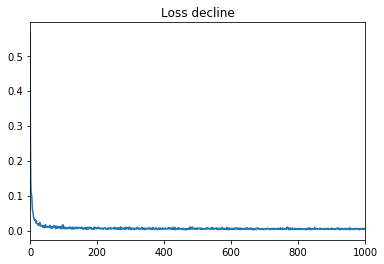

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [13]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Finished


In [14]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

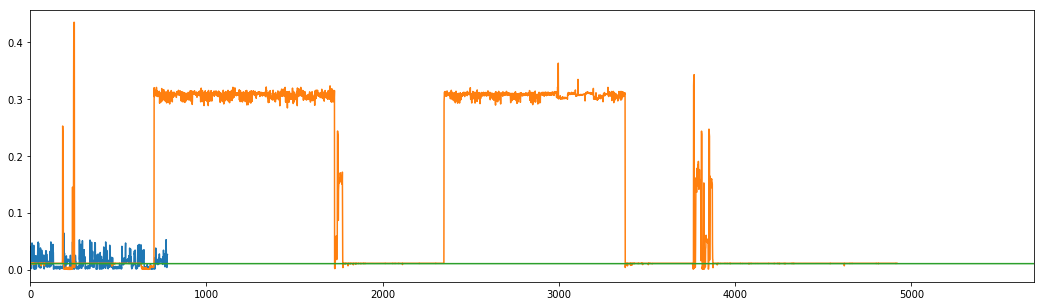

In [16]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()
bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
pd.Series(bar).plot(label="threshold")

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_kdd99_v1.ckpt
Model restored.
Initialized
Predict result :


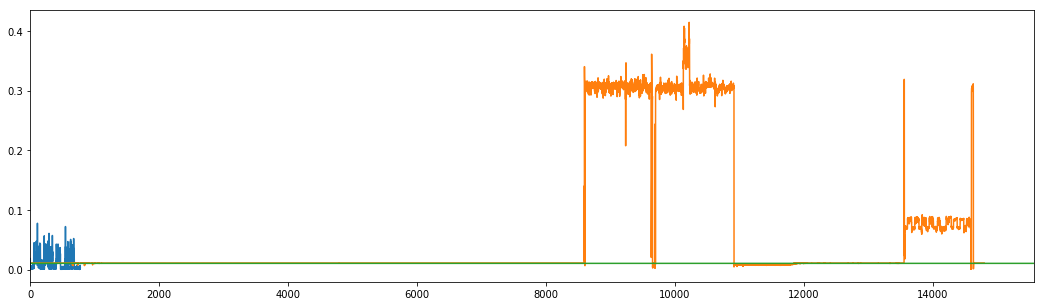

In [18]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [19]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9322889719588636

In [20]:
print(tp,fp,tn,fn,P,R)

13791 1009 516 264 0.9318243243243243 0.9812166488794023
